In [ ]:
from collections import Counter
import functools
import pathlib
import pickle
import random
import time
from typing import Callable, Dict, List, Optional, Set, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.cuda.is_available()

True

In [ ]:
#Set torch seed for reproducibility
torch.manual_seed(0)
torch.cuda.manual_seed(0)

## Data loading and preparation. 

In [ ]:
def read_file(path: str) -> List[List[str]]:
    """Loads data from file, return list of lists of words."""
    data = list()
    with open(path) as file:
        for line in file:
            line = line.strip()
            if len(line) == 0:
                # Skip empty lines.
                continue

            data.append(line.split())
    return data

In [ ]:
# root_dir = pathlib.Path("dataset")
root_dir = pathlib.Path("/content/drive/MyDrive/temp")

train_data = read_file(root_dir / "ptb.train.txt")
dev_data = read_file(root_dir / "ptb.valid.txt")
test_data = read_file(root_dir / "ptb.test.txt")

In [ ]:
# Build a vocabulary set + bos/eos tokens.
train_words = set()
word_counter = Counter()

for sentence in train_data:
    train_words.update(sentence)
    word_counter.update(sentence)

train_words.update(["<bos>", "<eos>"])
word_counter.update({"<bos>": len(train_data), "<eos>": len(train_data)})
print(f"Vocabulary of {len(train_words)} tokens was created.")

Vocabulary of 10001 tokens was created.


In [ ]:
class WordDict:
    """Class representing word dictionary. Provides mapping
    word to id and inverse."""
    def __init__(
        self,
        words: Union[List[str], Set[str]],
    ) -> None:
        
        self._word_to_id = dict()
        self._id_to_word = list()
        
        for word in words:
            self._word_to_id[word] = len(self._id_to_word)
            self._id_to_word.append(word)
        
    def __len__(self) -> int:
        """Return size of the dictionary."""
        return len(self._id_to_word)

    def word_to_id(self, word: str) -> int:
        """Map word into it's id."""
        return self._word_to_id[word]

    def id_to_word(self, idx: int) -> str:
        """Returns word coresponding to given id."""
        return self._id_to_word[idx]

In [ ]:
def sentence_to_tensor(
    word_dict: WordDict, 
    sentence: List[str],
) -> torch.Tensor:
    """Take list of words and transform it into a tensor of numbers.
    Adds BOS and EOS tokens at the beginnig and end of sentence 
    respectively.
    """
    bos = word_dict.word_to_id("<bos>")
    eos = word_dict.word_to_id("<eos>")
    sentence = [word_dict.word_to_id(word) for word in sentence]
    return torch.tensor([bos] + sentence + [eos])


def dataset_to_tensors(
    word_dict: WordDict,
    data: List[List[str]],
) -> List[torch.Tensor]:
    """Transform list of sentences into list of tensors
    representing the sentences."""
    return [sentence_to_tensor(word_dict, sentence) for sentence in data]


word_dict = WordDict(train_words)

train_tensor = dataset_to_tensors(word_dict, train_data)
dev_tensor = dataset_to_tensors(word_dict, dev_data)
test_tensor = dataset_to_tensors(word_dict, test_data)

# train_tensor[0].dtype # make sure it's integer type

### Language model module implementation

In [ ]:
class LMModuleBatch(nn.Module):
    """Language Model module implementation based on LSTM neural network.
    Implementation is created for batch processing.
    """
    
    def __init__(
        self,
        n_words: int,
        emb_size: int = 100,
        lstm_hidden_size: int = 200,
        n_lstm_layers: int = 1,
    ) -> None:
        """ LMModuleBatch for language modeling with batch processing.
        
        Parameters:
            n_words: size of the vocabulary.
            emb_size: size of the word embeddings.
            lstm_hidden_size: size of LSTM hidden layer.
            n_lstm_layers: number of LSTM layers.
        """
        
        super().__init__()
        
        # Create word embedding.
        self.embeddings = nn.Embedding(
            num_embeddings=n_words+1,
            embedding_dim=emb_size, 
            padding_idx=n_words,
        )
        
        # Create LSTM neural network.
        self.lstm = nn.LSTM(
            input_size=emb_size, # embedding size
            hidden_size=lstm_hidden_size,
            num_layers=n_lstm_layers,
            batch_first=True,
            bidirectional=False,
        )
        
        # Create fully connected projection layer.
        self.output_proj = nn.Linear(lstm_hidden_size, n_words)
        
    def forward(self, input_tensor):
        # Shape: (batch_size, sentence_len)
        if len(input_tensor.shape) < 2:
            raise RuntimeError("Batch data required.")
        
        # Shape: (batch_size, sentece_len, embedding_size)
        input_embs = self.embeddings(input_tensor)
        # Shape: (batch_size, sentence_len, hidden_size)
        hid, _ = self.lstm(input_embs)
        # Shape: (batch_size, sentence_len, n_words)
        logits = self.output_proj(hid)
        
        return logits

## Building data batches
Since we are dealing with sentences of various lenghts construction of data batches needs some workarounds. Padding will be used to extend shorter sentences within a batch to the lenght of the longest sentence in the batch. To minimize amount of padding used sentences are first sorted given their length. Hence, sentences of similar lenght should be grouped together in batches.

For sentence of len $n$ words $(1, n-1)$ are input data while $(2, n)$ are labels as we are predicting following word which cannot be done for the first or the last word. For example having a sentence _"I have a dog"_ inputs are _["\<bos\>", "I", "have", "a", "dog"]_ and labels are _["I", "have", "a", "dog", "\<eos\>"]_. Furthermore mask is a boolean tensor that will allow to select indices that represent existing words. This will allow to remove padding tokens from loss computation.

In [ ]:
def create_batches(
    data: List[torch.Tensor], 
    padding_idx: int,
    batch_size:int = 16,
) -> Tuple[List[torch.Tensor]]:
    """Build batches of data, labels and masks from 
    a list of tensors representing sentence data.
    Batches are constructed from sorted data to minimize
    the use of padding index.
    """
    # Sort the data in ascending lenght order.
    data = sorted(data, key=lambda x: -x.shape[0])

    data_batches = []
    label_batches = []
    mask_batches = []
    
    i = 0
    while i < len(data):
        # Get a slice of data of batch_size.
        batch_data = data[i:i+batch_size]
        
        # Extract sentences lenghts to get shape of the batch.
        # Batch size will be (batch_size, max(sentences_lenght)).
        sentence_lengths = [len(s) for s in batch_data]
        max_len = max(sentence_lengths)
        
        batch_labels = torch.zeros(len(batch_data), max_len-1, dtype=torch.int64)
        batch_mask = torch.zeros(len(batch_data), max_len-1, dtype=torch.bool)
        batch_input = torch.empty(len(batch_data), max_len-1, dtype=torch.int64)
        batch_input.fill_(padding_idx)
        
        for b in range(len(batch_data)):
            s = batch_data[b]
            batch_input[b, :len(s) - 1] = s[:-1]
            batch_labels[b, :len(s) - 1] = s[1:]
            batch_mask[b, :len(s) - 1] = True
        
        data_batches.append(batch_input)
        label_batches.append(batch_labels)
        mask_batches.append(batch_mask)
        
        i += batch_size
    
    return data_batches, label_batches, mask_batches

## Model train-valiate loop
Batched data is used for model trainig.

In [ ]:
def train_model(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    loss_function: Callable,
    softmax_function: Callable,
    train_data: List[torch.Tensor],
    dev_data: List[torch.Tensor],
    n_epochs: int = 10,
    batch_size: int = 16,
    bigram_softmax: bool = False,
    verbose: bool = True,
    use_gpu: bool = False,
) -> Tuple[List[float]]:
    """Perform training on given model. Composes given training 
    and validation data into batches of size `batch_size`.
    
    Parameters:
        model: model to train. 
        optimizer: optimizer to use during the training.
        loss_function: loss function that takes logits and target tensors.
        softmax_function: function to transform logits into probabilities.
        train_data: list of training data tensors.
        dev_data: list of validation data tensors.
        n_epochs: number of epochs.
        batch_size: size of batches to use.
        bigram_softmax: set `True` while using bigram distribution in softmax
                        approximation. Labels will be passed to softmax function.
        verbose: print information during training.
        use_gpu: whether to use gpu device during training.
    """
    time_start = time.time()

    device = torch.device('cuda' if use_gpu else 'cpu')
        
    model.to(device)
    
    # Pack training data into batched, data is sorted before 
    # so sentences within a batch have similar lenght hence
    # amount of padding is minimized.
    train_inputs, train_labels, train_masks = create_batches(
        train_data, 
        padding_idx=model.embeddings.padding_idx,
        batch_size=batch_size,
    )
    dev_inputs, dev_labels, dev_masks = create_batches(
        dev_data,
        padding_idx=model.embeddings.padding_idx,
        batch_size=batch_size,
    )

    # This index will be used to access batches in random order
    # after shuffling.
    data_index = list(range(len(train_inputs)))
    train_loss = []
    validation_loss = []
    for epoch in range(n_epochs):
        # Shuffle indices to access batches in random order.
        random.shuffle(data_index)

        # ~~~~~~~~~ Training Loop ~~~~~~~~~
        epoch_start_time = time.time()
        epoch_loss = 0
        epoch_norm = 0

        model.train()
        for batch_idx in data_index:
            optimizer.zero_grad()

            # Get batch data for current iteration.
            batch_input = train_inputs[batch_idx].to(device)
            batch_labels = train_labels[batch_idx].to(device)
            batch_mask = train_masks[batch_idx].to(device)

            # Pass the data through LSTM model.
            batch_logits = model(batch_input)
            # Transform logits into probabilities.
            if not bigram_softmax:
                batch_probas = softmax_function(batch_logits[batch_mask])
            else:
                batch_probas = softmax_function(
                    batch_logits[batch_mask], 
                    batch_input[batch_mask],
                )
            # Compute loss.
            batch_loss = loss_function(
                batch_probas,
                batch_labels[batch_mask],
            )

            # Normalize by number of letters predicted.
            batch_norm = sum(len(s)-1 for s in batch_input)
            loss = batch_loss / batch_norm
            
            epoch_loss += batch_loss.item()
            epoch_norm += batch_norm

            loss.backward()
            optimizer.step()
        # endfor
        train_loss.append(epoch_loss/epoch_norm)

        # ~~~~~~~~~ Validation Loop ~~~~~~~~~
        val_loss = 0
        val_norm = 0

        model.eval()
        with torch.no_grad():
            for dev_input, dev_label, dev_mask in zip(dev_inputs, dev_labels, dev_masks):
                dev_input = dev_input.to(device)
                dev_label = dev_label.to(device)
                dev_mask = dev_mask.to(device)
                
                dev_logits = model(dev_input)
                if not bigram_softmax:
                    dev_probas = softmax_function(dev_logits[dev_mask])
                else:
                    dev_probas = softmax_function(
                        dev_logits[dev_mask], 
                        dev_input[dev_mask],
                    )
                dev_loss = loss_function(
                    dev_probas,
                    dev_label[dev_mask],
                )
                dev_norm = sum(len(s)-1 for s in dev_input)
                val_loss += dev_loss.item()
                val_norm += dev_norm

        validation_loss.append(val_loss/val_norm)

        # ~~~~~~~~~ End of Epoch ~~~~~~~~~
        if verbose:
            epoch_total_time = int(time.time() - epoch_start_time)
            print(f"Epoch {epoch}: loss={epoch_loss/epoch_norm} "
                  f"val_loss={val_loss/val_norm} - {epoch_total_time}s")
    if verbose:
        total_time = int(time.time() - time_start)
        print(f"Training finished in {total_time}s")
    return train_loss, validation_loss

## Model evaluation using cross-entropy and perplexity

In [ ]:
def evaluate_model(
    model: nn.Module, 
    test_data: List[torch.Tensor], 
    batch_size: int = 64,
    use_gpu: bool = False,
) -> Tuple[float]:
    device = torch.device('cuda' if use_gpu else 'cpu')
    model.to(device)
    
    test_inputs, test_labels, test_masks = create_batches(
        test_data, 
        padding_idx=model.embeddings.padding_idx,
        batch_size=batch_size,
    )
    ce_score = 0
    ppl_score = 0

    model.eval()
    with torch.no_grad():
        for inputs, labels, mask in zip(test_inputs, test_labels, test_masks):
            inputs = inputs.to(device)
            labels = labels.to(device)
            mask = mask.to(device)
            
            logits = model(inputs)

            loss = 0
            ppl = 0
            for s in range(len(inputs)):
                # Batch contains sentences, perplexity will be computed 
                # per-sentence and averaged later
                mask_sentence = mask[s]
                # Returns -log(p(w))
                sum_log_p = F.cross_entropy(
                    logits[s][mask_sentence], 
                    labels[s][mask_sentence], 
                    reduction="sum",
                )
                N = len(inputs[s]) - 1
                mean_log_p = sum_log_p / N
                # Single sentence perplexity
                ppl += torch.exp(mean_log_p)
                # Single sentence cross entropy
                loss += mean_log_p

            # Average batch perplexity and cross entropy
            ppl_score += ppl / len(inputs)
            ce_score += loss / len(inputs)
    
    # Average test set CE and PPL
    cross_entropy = ce_score / len(test_inputs)
    perplexity = ppl_score / len(test_inputs)
    return cross_entropy, perplexity

## Run training and evaluate the model

In [ ]:
model = LMModuleBatch(
    n_words=len(word_dict),
    emb_size=60,
    lstm_hidden_size=600,
    n_lstm_layers=1,
)
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=1e-4,
    weight_decay=1e-5, # add L2 regularization
)

In [ ]:
cross_entropy, perplexity = evaluate_model(
    model=model, 
    test_data=test_tensor,
    batch_size=64,
    use_gpu=torch.cuda.is_available(),
)

print(f"Before training: cross_entropy: {cross_entropy}, perplexity: {perplexity}")

Before training: cross_entropy: 9.54638957977295, perplexity: 16371.8984375


Epoch 0: loss=6.775993269522487 val_loss=6.423040923990619 - 96s
Epoch 1: loss=6.3367304750459335 val_loss=6.163506344124843 - 100s
Epoch 2: loss=6.101132696596721 val_loss=5.994697138721241 - 96s
Epoch 3: loss=5.924179752010354 val_loss=5.857974780072846 - 96s
Epoch 4: loss=5.783325938618935 val_loss=5.774652210304243 - 96s
Epoch 5: loss=5.665832563130588 val_loss=5.687645029828967 - 96s
Epoch 6: loss=5.564319554247317 val_loss=5.629270698456908 - 96s
Epoch 7: loss=5.474721409397719 val_loss=5.55711625873826 - 96s
Epoch 8: loss=5.39363908836643 val_loss=5.5054825845595 - 96s
Epoch 9: loss=5.321092436665936 val_loss=5.463334384009256 - 96s
Epoch 10: loss=5.25329801076316 val_loss=5.429564196509717 - 96s
Epoch 11: loss=5.190629459552528 val_loss=5.394585676230032 - 96s
Epoch 12: loss=5.132456691821685 val_loss=5.36346328397165 - 96s
Epoch 13: loss=5.07815367130293 val_loss=5.339036681174077 - 96s
Epoch 14: loss=5.026845627253904 val_loss=5.32226449291293 - 96s
Epoch 15: loss=4.978483676

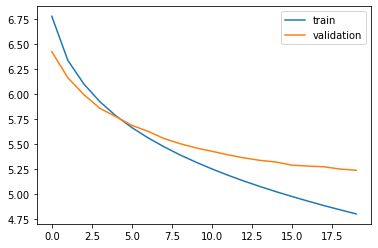

In [ ]:
neg_likelihood_loss = functools.partial(F.nll_loss, reduction="sum")
log_softmax = functools.partial(F.log_softmax, dim=1)

# Cross entropy: log_softmax + neg_likelihood_loss

train_loss, valid_loss = train_model(
    model=model,
    optimizer=optimizer,
    loss_function=neg_likelihood_loss,
    softmax_function=log_softmax,
    train_data=train_tensor,
    dev_data=dev_tensor,
    n_epochs=20,
    batch_size=16,
    verbose=True,
    use_gpu=torch.cuda.is_available(),
)

# torch.save(model, root_dir / 'lstm_model_emb_100_hidden_1000.pth')

plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(["train", "validation"])
plt.show()

In [ ]:
cross_entropy, perplexity = evaluate_model(
    model=model, 
    test_data=test_tensor,
    batch_size=64,
    use_gpu=torch.cuda.is_available(),
)
print(f"After training: cross_entropy: {cross_entropy}, perplexity: {perplexity}")

After training: cross_entropy: 5.178591251373291, perplexity: 410.1605224609375


## Evaluation within frequency bins

The goal is to split vocabulary into frequency bins of equal size and perform evaluation on test set with computing cross entropy and perplexity scores for each of the bins. Depending on the label value loss will be accumulated into $\text{total_bin}$ value and then normalized. 


In [ ]:
def freq_bins_evaluation(
    model: nn.Module,
    test_data: List[torch.Tensor],
    word_dict: WordDict,
    word_counter: Counter,
    n_bins: int = 5,
    batch_size: int = 64,
    use_gpu: bool = False,
) -> Dict[int, float]:

    device = torch.device('cuda' if use_gpu else 'cpu')
    model.to(device)
    
    bin_map = dict()
    # Sort words in ascending frequency order.
    word_to_freq = [(word, word_counter[word]) for word in word_counter]
    word_to_freq.sort(key=lambda x: -x[1])

    # Size of a single bin.
    bin_size = len(word_to_freq) // n_bins
    # Assing words into bins.
    n_bin = 0
    for i in range(n_bins):
        bin = word_to_freq[n_bin:n_bin+bin_size]
        for word, _ in bin:
            bin_map[word_dict.word_to_id(word)] = i
        n_bin += bin_size

    # For storing the results.
    bin_scores = {i: list() for i in range(n_bins)}

    test_inputs, test_labels, test_masks = create_batches(
        test_data, 
        padding_idx=model.embeddings.padding_idx,
        batch_size=batch_size,
    )

    model.eval()
    with torch.no_grad():
        for inputs, labels, mask in zip(test_inputs, test_labels, test_masks):
            inputs = inputs.to(device)
            labels = labels.to(device)
            mask = mask.to(device)
            
            logits = model(inputs)
            # shape: (len(labels[mask]), )
            loss = F.cross_entropy(
                logits[mask], 
                labels[mask], 
                reduction="none",
            )
            
            for ce, word in zip(loss, labels[mask]):
                bin_id = bin_map[word.item()]
                bin_scores[bin_id].append(ce.item())
        
    # Return mean score for each bin.
    return [np.mean(bin_scores[bin_id]) for bin_id in range(len(bin_scores))]

In [ ]:
bin_scores = freq_bins_evaluation(
    model=model,
    test_data=test_tensor,
    word_dict=word_dict,
    word_counter=word_counter,
    n_bins=5,
    batch_size=64,
    use_gpu=torch.cuda.is_available(),
)

pickle.dump(bin_scores, open(root_dir / "bis_kl_60_600.pkl", "wb"))

plt.bar(list(range(len(bin_scores))), bin_scores)
plt.show()

## Power divergences

### $\alpha$-divergences

\begin{equation}
\textit{Obj}_{\alpha}(\theta) = \frac{1}{\alpha(\alpha-1)} \sum_{(x,y)\in \mathcal{D}} \left(p_{\theta}(y|x)\right)^{1-\alpha}
\end{equation}

### $\beta$-divergences

\begin{equation}
\textit{Obj}_{\beta}(\theta) = \frac{1}{\beta(\beta-1)} \sum_{(x,y)\in \mathcal{D}} \left[ (\beta - 1)\sum_{y' \in \mathcal{Y}} \left(p_{\theta}(y'|x)\right)^{\beta} - \beta \left(p_{\theta}(y|x)\right)^{\beta-1}\right]
\end{equation}

### $\gamma$-divergences

\begin{equation}
\textit{Obj}_{\gamma}(\theta) = \sum_{(x,y)\in \mathcal{D}} \left[ \log p_{\theta}(y|x) - \frac{1}{\gamma} \log \sum_{y' \in \mathcal{Y}} \left(p_{\theta}(y'|x)\right)^{\gamma} \right]
\end{equation}

In [ ]:
def sum_p(logits, targets):
    """Returns sum(p(y|x)) for given logits and targets."""
    return -torch.sum(logits.gather(1, targets.view(-1, 1)))


def alpha_divergence(logits: torch.Tensor, targets: torch.Tensor, alpha: float):
    p_y_given_x = logits.gather(1, targets.view(-1, 1)) + 1e-5
    return torch.sum(p_y_given_x**(1-alpha)) / (alpha*(alpha-1))


def beta_divergence(logits: torch.Tensor, targets: torch.Tensor, beta: float):
    c = beta - 1
    p_y_given_x = logits.gather(1, targets.view(-1, 1)).squeeze()
    sum_p_yp_given_x = torch.sum((logits + 1e-5)**beta, axis=-1)  # sum(p(y'|x)^beta)
    return torch.sum(c * sum_p_yp_given_x - beta * p_y_given_x**c) / (beta * c)


def gamma_divergence(logits: torch.Tensor, targets: torch.Tensor, gamma: float):
    p_y_given_x = logits.gather(1, targets.view(-1, 1)).squeeze()
    log_p_y_given_x = torch.log(p_y_given_x + 1e-5) # log(p(y|x))
    sum_p_yp_given_x = torch.sum((logits + 1e-5)**gamma, axis=-1) # sum(p(y'|x)^gamma)
    return torch.sum(log_p_y_given_x - torch.log(sum_p_yp_given_x) / gamma)

## Approximated distributions

### Uniform
Uniform distribution words distribution is simply given by a formula $p(w) = \frac{1}{|V|}$, where $V$ is the vocabulary of the dataset.


### Unigram
Unigram distribution is given by a formula $p(w) = \frac{c(w)}{|W|}$ where $c(w)$ is the number of occurences of word $w$ in the text $W$ and $|W|$ is the total number of words. 

Smoothing for this distribution may be done using: 
- distortion coefficient 
$$p(w) = \frac{(c(w))^\alpha}{Z}$$
- Good-Turing smoothing

### Bigram
Bigram distribution $p(w | w_{prev}) = \frac{c(w,w_{prev})}{c(w_{prev})}$ (assuming that all sentences ends with `<eos>` token and it doesn't occur in other places in the sentences).

Smoothing for this distrubution may be done using: 
- Katz smoothing
- Modified Knese-Ney smooothing

In [ ]:
def count_words(text_data: List[List[str]]) -> Tuple[int, Counter]:
    word_counter = Counter()
    word_total = 0
    for s in text_data:
        sentence = ["<bos>"] + s + ["<eos>"]
        word_total += len(sentence)
        word_counter.update(sentence)

    return word_total, word_counter


def get_uniform_dist(word_dict: WordDict) -> torch.Tensor:
    """Construct uniform distribution from text data.
    Each word has the same probability q(w) = 1/#vocabulary_size
    """
    return torch.ones(len(word_dict)) / len(word_dict)


def get_unigram_dist(
    text_data: List[List[str]],
    word_dict: WordDict,
    alpha: Optional[float] = None,
) -> torch.Tensor:
    """Construct unigram distribution from text data.
    Word w is choosen with probability q(w) = #occurences_w/#number_of_words
    """
    word_total, word_counter = count_words(text_data)
    word_counts = np.array([word_counter[word_dict.id_to_word(i)]
                            for i in range(len(word_dict))])
    if alpha is None:
        return torch.Tensor(word_counts / word_total)
    else:
        smooth = word_counts ** alpha
        # nc = np.array(smooth)
        return torch.Tensor(smooth / np.sum(smooth))


def get_bigram_dist(
    text_data: List[List[str]],
    word_dict: WordDict,
) -> torch.Tensor:
    """Construct bigram distribution from empitical data.
    Generates a table of q(w | w_prev) values where
    q(w | w_prev) = #occurences of the sequence "w_prev w" / #occurences of w_prev in the data
    """
    n = len(word_dict)
    probs = np.zeros((n, n))
    word_count = Counter()

    for s in text_data:
        sentence = ["<bos>"] + s + ["<eos>"]
        word_count.update(sentence)

        for i in range(1, len(sentence)):
            w_prev = word_dict.word_to_id(sentence[i-1])
            w = word_dict.word_to_id(sentence[i])
            probs[w][w_prev] += 1

    for i in range(n):
        w_prev = word_dict.id_to_word(i)
        probs[:, i] /= word_count[w_prev]

    eos_id = word_dict.word_to_id("<eos>")
    probs[:, eos_id] = 0

    return torch.Tensor(probs)


def get_bigram_kn_smooth(
    text_data: List[List[str]],
    word_dict: WordDict,
    alpha: float = 0.75,
) -> torch.Tensor:
    """Kneser–Ney smoothing for bigram distribution."""

    bigrams = set()
    n_words = len(word_dict)
    bigram_count = np.zeros((n_words, n_words))

    for s in text_data:
        sentence = ["<bos>"] + s + ["<eos>"]
        for i in range(1, len(sentence)):
            w_prev = word_dict.word_to_id(sentence[i-1])
            w = word_dict.word_to_id(sentence[i])
            bigrams.add((w_prev, w))
            bigram_count[w][w_prev] += 1

    n_bigrams = len(bigrams)
    # Create p(w) unigram probability table
    # p(w) = |{w': c(w', w) > 0}| / |{(w', w''): c(w', w'') > 0}|
    p_w = np.zeros(n_words)
    for i in range(n_words):
        p_w[i] = np.sum(bigram_count[i, :] > 0) / n_bigrams

    eos_id = word_dict.word_to_id("<eos>")
    # Compute sum_{w'}(c(w, w')) for every w
    sum_c_w_wp_given_wp = np.array(
        [np.sum(bigram_count[:, i]) for i in range(n_words)])
    sum_c_w_wp_given_wp[eos_id] = -1 # to avoid zero-division

    # Create table of normalizing constants
    # lambd(w) = [ alpha / sum_{w'}(c(w, w')) ] * |{w': c(w, w') > 0}|
    n_bigrams_given_wp = np.array(
        [np.sum(bigram_count[:, i] > 0) for i in range(n_words)])
    # Normalizing constant for given w_prev
    lambd_w = (alpha / sum_c_w_wp_given_wp) * n_bigrams_given_wp
    
    probs = np.zeros((n_words, n_words))
    # for w in range(n_words):
        # t1 = np.maximum(bigram_count[w,:] - alpha, 0) / sum_c_w_wp_given_wp
        # t2 = lambd_w * p_w[w]
        # probs[w] = t1 + t2
    probs = (
        np.maximum(bigram_count - alpha, 0) / sum_c_w_wp_given_wp + lambd_w * p_w.reshape((n_words, 1)))

    # <eos> is never a w_prev
    probs[:, eos_id] = 0

    return torch.Tensor(probs)

## Approximated softmax
\begin{equation}
p_{\theta}(y|x) \approx \frac{\frac{\exp(s_{\theta}(x,y))}{p_n(y)}}{\frac{\exp({s_{\theta}(x,y))}}{p_{n}(y)} + \sum_{\hat{y}_i\sim p_{n}}\frac{\exp(s_{\theta}(x, \hat{y}_i))}{p_{n}(\hat{y}_i)}},
\end{equation}

where $p_n$ is approximated distribution built from the training set. In the following code we are going to consider 'uniform', 'unigram' and 'bigram' distributions.

In [ ]:
class ApproximatedSoftmax:

    def __init__(
        self,
        q: torch.Tensor,
        dist: torch.Tensor,
        k: int = 1000,
        bigram: bool = False,
    ) -> None:

        self._k = k
        self._q = q
        self._bigram = bigram
        self._dist = torch.distributions.Categorical(probs=dist).probs
        

    def __call__(
        self, 
        logits: torch.Tensor, 
        labels: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        # Sample from the empirical distribution of the train dataset.
        samples_idx = self._dist.multinomial(
            num_samples=self._k,
            replacement=True,
        )

        if self._bigram:
            # In case of bigram q(w | w_prev) is used. For that
            # inputs are used as a vector of w_prev since teacher forcing method
            # is used for training.
            if labels is None:
                raise RuntimeError("Bigram approx requires original inputs.")

            q = self._q[:, labels].T + 1e-5 # avoid zero division

            dist_sample = torch.sum(
                torch.exp(logits[:, samples_idx]) / q[:, samples_idx],
                dim=1,
                keepdim=True,
            )

        else:
            
            q = self._q
            dist_sample = torch.sum(
                torch.exp(logits[:, samples_idx]) / q[samples_idx],
                dim=1,
                keepdim=True,
            )

        exp_p = torch.exp(logits) / q
        return exp_p / (exp_p + dist_sample)

#Experiments - testing power divergences

In [ ]:
def train_model(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    loss_function: Callable,
    softmax_function: Callable,
    train_data: List[torch.Tensor],
    dev_data: List[torch.Tensor],
    n_epochs: int = 10,
    batch_size: int = 16,
    bigram_softmax: bool = False,
    verbose: bool = True,
    use_gpu: bool = False,
) -> Tuple[List[float]]:
    """Perform training on given model. Composes given training 
    and validation data into batches of size `batch_size`.
    
    Parameters:
        model: model to train. 
        optimizer: optimizer to use during the training.
        loss_function: loss function that takes logits and target tensors.
        softmax_function: function to transform logits into probabilities.
        train_data: list of training data tensors.
        dev_data: list of validation data tensors.
        n_epochs: number of epochs.
        batch_size: size of batches to use.
        bigram_softmax: set `True` while using bigram distribution in softmax
                        approximation. Labels will be passed to softmax function.
        verbose: print information during training.
        use_gpu: whether to use gpu device during training.
    """
    time_start = time.time()

    device = torch.device('cuda' if use_gpu else 'cpu')
        
    model.to(device)
    
    # Pack training data into batched, data is sorted before 
    # so sentences within a batch have similar lenght hence
    # amount of padding is minimized.
    train_inputs, train_labels, train_masks = create_batches(
        train_data, 
        padding_idx=model.embeddings.padding_idx,
        batch_size=batch_size,
    )
    dev_inputs, dev_labels, dev_masks = create_batches(
        dev_data,
        padding_idx=model.embeddings.padding_idx,
        batch_size=batch_size,
    )

    # This index will be used to access batches in random order
    # after shuffling.
    data_index = list(range(len(train_inputs)))
    train_loss = []
    validation_loss = []
    #Maja - added val crossentropy
    val_cross_entropy = []
    for epoch in range(n_epochs):
        # Shuffle indices to access batches in random order.
        random.shuffle(data_index)

        # ~~~~~~~~~ Training Loop ~~~~~~~~~
        epoch_start_time = time.time()
        epoch_loss = 0
        epoch_norm = 0

        model.train()
        for batch_idx in data_index:
            optimizer.zero_grad()

            # Get batch data for current iteration.
            batch_input = train_inputs[batch_idx].to(device)
            batch_labels = train_labels[batch_idx].to(device)
            batch_mask = train_masks[batch_idx].to(device)

            # Pass the data through LSTM model.
            batch_logits = model(batch_input)
            # Transform logits into probabilities.
            if not bigram_softmax:
                batch_probas = softmax_function(batch_logits[batch_mask])
            else:
                batch_probas = softmax_function(
                    batch_logits[batch_mask], 
                    batch_input[batch_mask],
                )
            # Compute loss.
            
            batch_loss = loss_function(
                batch_probas,
                batch_labels[batch_mask],
            )
            # Normalize by number of letters predicted.
            batch_norm = sum(len(s)-1 for s in batch_input)
            loss = batch_loss / batch_norm
            
            epoch_loss += batch_loss.item()
            epoch_norm += batch_norm

            loss.backward()
            optimizer.step()
        # endfor
        train_loss.append(epoch_loss/epoch_norm)

        # ~~~~~~~~~ Validation Loop ~~~~~~~~~
        val_loss = 0
        val_norm = 0
        ce_score = 0

        model.eval()
        with torch.no_grad():
            for dev_input, dev_label, dev_mask in zip(dev_inputs, dev_labels, dev_masks):
                dev_input = dev_input.to(device)
                dev_label = dev_label.to(device)
                dev_mask = dev_mask.to(device)
                
                dev_logits = model(dev_input)
                if not bigram_softmax:
                    dev_probas = softmax_function(dev_logits[dev_mask])
                else:
                    dev_probas = softmax_function(
                        dev_logits[dev_mask], 
                        dev_input[dev_mask],
                    )
                dev_loss = loss_function(
                    dev_probas,
                    dev_label[dev_mask],
                )
                dev_norm = sum(len(s)-1 for s in dev_input)
                val_loss += dev_loss.item()
                val_norm += dev_norm

                #computing cross-entropy on dev set for current epoch
                sentence_crossentropy = 0
                for s in range(len(dev_input)):
                    mask_sentence = dev_mask[s]
                    # Returns -log(p(w))
                    sum_log_p = F.cross_entropy(
                        dev_logits[s][mask_sentence], 
                        dev_label[s][mask_sentence], 
                        reduction="sum",
                    )
                    N = len(dev_input[s]) - 1
                    mean_log_p = sum_log_p / N
                    # Single sentence cross entropy
                    sentence_crossentropy += mean_log_p

                # Average batch cross entropy
                ce_score += sentence_crossentropy / len(dev_input)

        
        validation_loss.append(val_loss/val_norm)
        val_cross_entropy.append(ce_score / len(dev_inputs))

        # ~~~~~~~~~ End of Epoch ~~~~~~~~~
        if verbose:
            epoch_total_time = int(time.time() - epoch_start_time)
            print(f"Epoch {epoch}: loss={epoch_loss/epoch_norm} "
                  f"val_loss={val_loss/val_norm} - {epoch_total_time}s")
    if verbose:
        total_time = int(time.time() - time_start)
        print(f"Training finished in {total_time}s")
    return train_loss, validation_loss, val_cross_entropy

In [ ]:
def freq_bins_evaluation(
    model: nn.Module,
    test_data: List[torch.Tensor],
    word_dict: WordDict,
    word_counter: Counter,
    n_bins: int = 5,
    batch_size: int = 64,
    use_gpu: bool = False,
) -> Dict[int, float]:

    device = torch.device('cuda' if use_gpu else 'cpu')
    model.to(device)
    
    bin_map = dict()
    # Sort words in ascending frequency order.
    word_to_freq = [(word, word_counter[word]) for word in word_counter]
    word_to_freq.sort(key=lambda x: -x[1])

    # Size of a single bin.
    bin_size = len(word_to_freq) // n_bins
    # Assing words into bins.
    n_bin = 0
    for i in range(n_bins):
        bin = word_to_freq[n_bin:n_bin+bin_size]
        for word, _ in bin:
            bin_map[word_dict.word_to_id(word)] = i
        n_bin += bin_size

    # For storing the results.
    bin_scores = {i: list() for i in range(n_bins)}
    #Maja  - added perplexity
    bin_perplexity = {i: list() for i in range(n_bins)}

    test_inputs, test_labels, test_masks = create_batches(
        test_data, 
        padding_idx=model.embeddings.padding_idx,
        batch_size=batch_size,
    )

    model.eval()
    with torch.no_grad():
        for inputs, labels, mask in zip(test_inputs, test_labels, test_masks):
            inputs = inputs.to(device)
            labels = labels.to(device)
            mask = mask.to(device)
            
            logits = model(inputs)
            # shape: (len(labels[mask]), )
            loss = F.cross_entropy(
                logits[mask], 
                labels[mask], 
                reduction="none",
            )
            perplexity = torch.exp(loss)
            
            for ce, ppl, word in zip(loss, perplexity, labels[mask]):
                bin_id = bin_map[word.item()]
                bin_scores[bin_id].append(ce.item())
                bin_perplexity[bin_id].append(ppl.item())
        
    # Return mean score for each bin.
    return (
        [np.mean(bin_scores[bin_id]) for bin_id in range(len(bin_scores))],
        [np.mean(bin_perplexity[bin_id]) for bin_id in range(len(bin_scores))],
    )

# Experiment - testing NLL with exact softmax

Epoch 0: loss=6.776301280519315 val_loss=6.4196154478854615 - 26s
Epoch 1: loss=6.33477106129025 val_loss=6.162117633606333 - 26s
Epoch 2: loss=6.099302167425148 val_loss=5.991033663171324 - 26s
Epoch 3: loss=5.922525736250796 val_loss=5.854441084909158 - 26s
Epoch 4: loss=5.778994103062903 val_loss=5.7593262752002365 - 25s
Epoch 5: loss=5.660141255221039 val_loss=5.674258453769636 - 25s
Epoch 6: loss=5.557349219604612 val_loss=5.603668502841565 - 25s
Epoch 7: loss=5.464977787093784 val_loss=5.55257503895514 - 25s
Epoch 8: loss=5.384152564483888 val_loss=5.495121685338439 - 25s
Epoch 9: loss=5.309333628534537 val_loss=5.450067228418082 - 25s
Epoch 10: loss=5.240538945742707 val_loss=5.416261707834352 - 25s
Epoch 11: loss=5.17666466869905 val_loss=5.388923213369707 - 25s
Epoch 12: loss=5.116456541593709 val_loss=5.363157681804598 - 25s
Epoch 13: loss=5.06135881431055 val_loss=5.333330722235059 - 25s
Epoch 14: loss=5.007712880773766 val_loss=5.314975366176388 - 25s
Training finished in 4

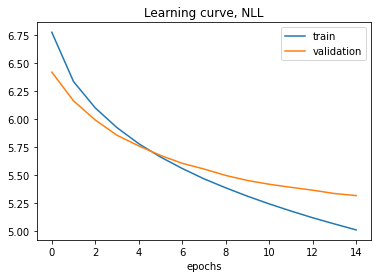

Model evaluation after training with NLL: cross_entropy: 5.241140842437744, perplexity: 443.9385070800781


In [ ]:
#full_softmax = functools.partial(F.softmax, dim=1)
#approx_softmax = ApproximatedSoftmax(q, dist, 1000, bigram=True)
#softmax = functools.partial(F.softmax, dim=1)
neg_likelihood_loss = functools.partial(F.nll_loss, reduction="sum")
log_softmax = functools.partial(F.log_softmax, dim=1)
cross_entropies_nll_full= [] 
perplexities_nll_full = []
validation_crossentropies_nll_full = []
bin_cross_entropies_nll_full= [] 
bin_perplexities_nll_full = []

model = LMModuleBatch(
    n_words=len(word_dict),
    emb_size=60,
    lstm_hidden_size=600,
    n_lstm_layers=1,
)

optimizer_pd = torch.optim.Adam(
    model.parameters(), 
    lr=1e-4,
    weight_decay=1e-5, # add L2 regularization
)

train_loss, valid_loss, valid_cross_entropy = train_model(
    model=model,
    optimizer=optimizer_pd,
    loss_function=neg_likelihood_loss,
    softmax_function=log_softmax,
    train_data=train_tensor,
    dev_data=dev_tensor,
    n_epochs=15,
    batch_size=16,
    bigram_softmax=False,
    verbose=True,
    use_gpu=torch.cuda.is_available(),
)

validation_crossentropies_nll_full.append(valid_cross_entropy)

plt.figure()
plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(["train", "validation"])
plt.title('Learning curve, NLL')
plt.xlabel('epochs')
plt.show()

cross_entropy, perplexity = evaluate_model(
    model=model, 
    test_data=dev_tensor,
    batch_size=64,
    use_gpu=torch.cuda.is_available(),
)
print(f"Model evaluation after training with NLL:"
      f" cross_entropy: {cross_entropy}, perplexity: {perplexity}")
cross_entropies_nll_full.append(cross_entropy)
perplexities_nll_full.append(perplexity)

bin_ce, bin_ppl = freq_bins_evaluation(
    model=model,
    test_data=test_tensor,
    word_dict=word_dict,
    word_counter=word_counter,
    n_bins=5,
    batch_size=64,
    use_gpu=torch.cuda.is_available(),
)
bin_cross_entropies_nll_full.append(bin_ce)
bin_perplexities_nll_full.append(bin_ppl)

# Experiment - testing different alpha parameter values with alpha-divergence as exact objective



Epoch 0: loss=-1.1077257926632775 val_loss=-1.2074667782538973 - 25s
Epoch 1: loss=-1.2494069747361836 val_loss=-1.2782714754261622 - 24s
Epoch 2: loss=-1.3154451174690855 val_loss=-1.3378837987985777 - 24s
Epoch 3: loss=-1.3708142877930356 val_loss=-1.3906748729850733 - 25s
Epoch 4: loss=-1.414412844790324 val_loss=-1.4277599730807613 - 24s
Epoch 5: loss=-1.4500024270306247 val_loss=-1.4577371976031068 - 24s
Epoch 6: loss=-1.4808590203002672 val_loss=-1.4868433524576021 - 24s
Epoch 7: loss=-1.508744036496756 val_loss=-1.5142145803851657 - 24s
Epoch 8: loss=-1.5336159069745794 val_loss=-1.528877397099082 - 24s
Epoch 9: loss=-1.5557472531046377 val_loss=-1.5362478722091555 - 24s
Epoch 10: loss=-1.5764394108345352 val_loss=-1.5725439798358916 - 24s
Epoch 11: loss=-1.5952536198052678 val_loss=-1.5753876614843891 - 24s
Epoch 12: loss=-1.612600285735119 val_loss=-1.601731137572173 - 24s
Epoch 13: loss=-1.6297050453342425 val_loss=-1.6098121825266034 - 24s
Epoch 14: loss=-1.6453029021623502 

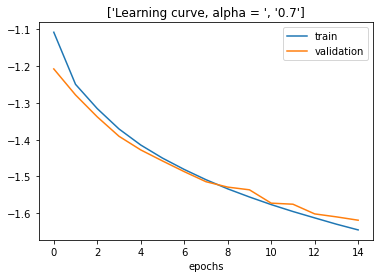

Model evaluation after training with alpha = 0.7: cross_entropy: 6.406655311584473, perplexity: 2204.059814453125
Epoch 0: loss=-6.408552441026349 val_loss=-6.545318148231415 - 24s
Epoch 1: loss=-6.6586786623223215 val_loss=-6.687938583938241 - 24s
Epoch 2: loss=-6.788524084248788 val_loss=-6.800893998051385 - 24s
Epoch 3: loss=-6.889865133630133 val_loss=-6.8877552873317685 - 24s
Epoch 4: loss=-6.972324137138568 val_loss=-6.951504573882719 - 24s
Epoch 5: loss=-7.040713726875259 val_loss=-6.998180449457122 - 24s
Epoch 6: loss=-7.1003407754219685 val_loss=-7.060010393354282 - 24s
Epoch 7: loss=-7.152637431672636 val_loss=-7.100702481018855 - 24s
Epoch 8: loss=-7.200431109633443 val_loss=-7.133665413195684 - 24s
Epoch 9: loss=-7.243898447169964 val_loss=-7.159780505595921 - 24s
Epoch 10: loss=-7.283582579354663 val_loss=-7.191047876439624 - 24s
Epoch 11: loss=-7.320521411268523 val_loss=-7.214517624269634 - 24s
Epoch 12: loss=-7.354805317411386 val_loss=-7.241374527197124 - 24s
Epoch 13:

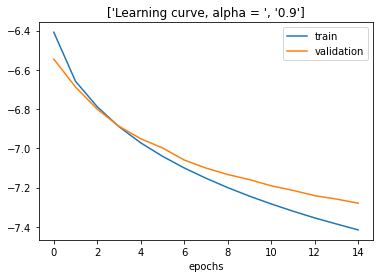

Model evaluation after training with alpha = 0.9: cross_entropy: 5.416708469390869, perplexity: 598.6444702148438
Epoch 0: loss=18.66746484453405 val_loss=18.04736742972925 - 24s
Epoch 1: loss=17.980692390688592 val_loss=17.638213156928664 - 24s
Epoch 2: loss=17.605067385822306 val_loss=17.386990666614395 - 24s
Epoch 3: loss=17.3260873429103 val_loss=17.183749450324353 - 24s
Epoch 4: loss=17.104756880183018 val_loss=17.023857742151005 - 25s
Epoch 5: loss=16.9186018492832 val_loss=16.89899619538989 - 25s
Epoch 6: loss=16.760048879532185 val_loss=16.815345309305663 - 26s
Epoch 7: loss=16.619464880908424 val_loss=16.70442045052206 - 26s
Epoch 8: loss=16.48944738830816 val_loss=16.636312449987923 - 26s
Epoch 9: loss=16.371305322812685 val_loss=16.58019840296664 - 24s
Epoch 10: loss=16.263762252562532 val_loss=16.528066561274382 - 24s
Epoch 11: loss=16.161532603123877 val_loss=16.478356404441342 - 24s
Epoch 12: loss=16.067330239008843 val_loss=16.45131445050545 - 25s
Epoch 13: loss=15.97808

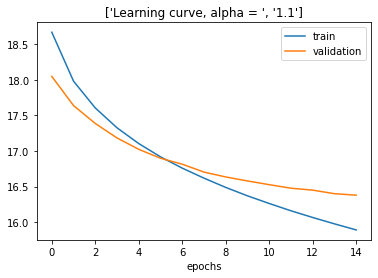

Model evaluation after training with alpha = 1.1: cross_entropy: 5.279361248016357, perplexity: 531.3552856445312
Epoch 0: loss=23.766960355415996 val_loss=22.07336425308562 - 24s
Epoch 1: loss=21.323489781897063 val_loss=20.768732530665368 - 24s
Epoch 2: loss=19.958090353341333 val_loss=19.94152830183471 - 24s
Epoch 3: loss=18.963789488152567 val_loss=19.403740302407652 - 24s
Epoch 4: loss=18.179078461013837 val_loss=18.988760574677286 - 24s
Epoch 5: loss=17.522337301494453 val_loss=18.7005960674555 - 24s
Epoch 6: loss=16.953835629911936 val_loss=18.520356538251498 - 24s
Epoch 7: loss=16.441718293480307 val_loss=18.345646274848868 - 24s
Epoch 8: loss=15.97271006070722 val_loss=18.212454482064075 - 24s
Epoch 9: loss=15.542160099436943 val_loss=18.122684394857696 - 24s
Epoch 10: loss=15.14185983438792 val_loss=18.031600061346957 - 24s
Epoch 11: loss=14.768229000837406 val_loss=17.977275546405682 - 25s
Epoch 12: loss=14.417625915644594 val_loss=17.92518684649119 - 25s
Epoch 13: loss=14.0

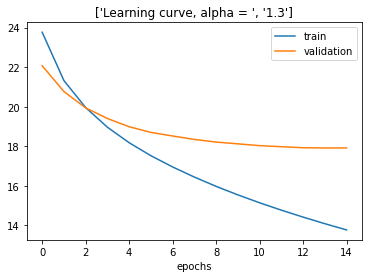

Model evaluation after training with alpha = 1.3: cross_entropy: 5.456691741943359, perplexity: 491.190673828125


In [ ]:
full_softmax = functools.partial(F.softmax, dim=1)
#approx_softmax = ApproximatedSoftmax(q, dist, 1000, bigram=True)
#softmax = functools.partial(F.softmax, dim=1)
cross_entropies_a_full= [] 
perplexities_a_full = []
validation_crossentropies_a_full = []
bin_cross_entropies_a_full= [] 
bin_perplexities_a_full = []

for alpha_val in [0.7, 0.9, 1.1, 1.3]:
  
  alpha_divergence_loss = functools.partial(alpha_divergence, alpha=alpha_val)

  model = LMModuleBatch(
      n_words=len(word_dict),
      emb_size=60,
      lstm_hidden_size=600,
      n_lstm_layers=1,
  )

  optimizer_pd = torch.optim.Adam(
      model.parameters(), 
      lr=1e-4,
      weight_decay=1e-5, # add L2 regularization
  )

  train_loss, valid_loss, valid_cross_entropy = train_model(
      model=model,
      optimizer=optimizer_pd,
      loss_function=alpha_divergence_loss,
      softmax_function=full_softmax,
      train_data=train_tensor,
      dev_data=dev_tensor,
      n_epochs=15,
      batch_size=16,
      bigram_softmax=False,
      verbose=True,
      use_gpu=torch.cuda.is_available(),
  )

  validation_crossentropies_a_full.append(valid_cross_entropy)

  plt.figure()
  plt.plot(train_loss)
  plt.plot(valid_loss)
  plt.legend(["train", "validation"])
  plt.title(['Learning curve, alpha = ',str(alpha_val)])
  plt.xlabel('epochs')
  plt.show()

  cross_entropy, perplexity = evaluate_model(
      model=model, 
      test_data=dev_tensor,
      batch_size=64,
      use_gpu=torch.cuda.is_available(),
  )
  print(f"Model evaluation after training with alpha = {alpha_val}: cross_entropy: {cross_entropy}, perplexity: {perplexity}")
  cross_entropies_a_full.append(cross_entropy)
  perplexities_a_full.append(perplexity)

  bin_ce, bin_ppl = freq_bins_evaluation(
      model=model,
      test_data=test_tensor,
      word_dict=word_dict,
      word_counter=word_counter,
      n_bins=5,
      batch_size=64,
      use_gpu=torch.cuda.is_available(),
  )
  bin_cross_entropies_a_full.append(bin_ce)
  bin_perplexities_a_full.append(bin_ppl)

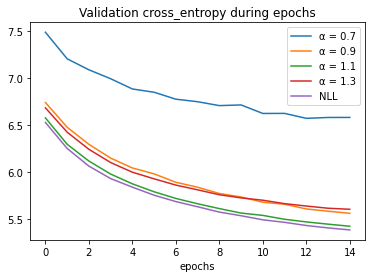

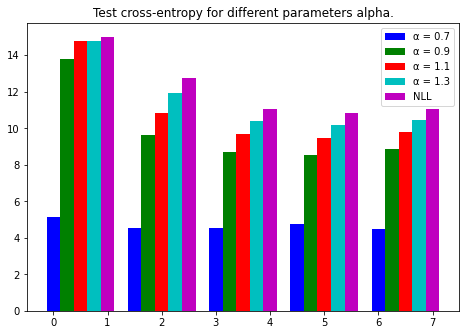

In [ ]:
alpha_val = [0.7, 0.9, 1.1, 1.3]
plt.figure()
for valid_cross_entropy in validation_crossentropies_a_full:
  plt.plot(valid_cross_entropy)
for valid_cross_entropy in validation_crossentropies_nll_full:
  plt.plot(valid_cross_entropy)
plt.legend([f"α = {alpha}" for alpha in alpha_val]+['NLL'])
plt.title('Validation cross_entropy during epochs')
plt.xlabel('epochs')
plt.show()

X = np.array([k*1.5 for k in range(5)])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bin_CE = [row[:] for row in bin_cross_entropies_a_full]
bin_CE.append([t for t in bin_cross_entropies_nll_full[0]])

ax.bar(X + 0.00, [bin_CE[k][0] for k in range(len(bin_CE))], color = 'b', width = 0.25, label=f"α = {alpha_val[0]}")
ax.bar(X + 0.25, [bin_CE[k][1] for k in range(len(bin_CE))], color = 'g', width = 0.25, label=f"α = {alpha_val[1]}")
ax.bar(X + 0.50, [bin_CE[k][2] for k in range(len(bin_CE))], color = 'r', width = 0.25, label=f"α = {alpha_val[2]}")
ax.bar(X + 0.75, [bin_CE[k][3] for k in range(len(bin_CE))], color = 'c', width = 0.25, label=f"α = {alpha_val[3]}")
ax.bar(X + 1.0, [bin_CE[k][4] for k in range(len(bin_CE))], color = 'm', width = 0.25, label="NLL")

plt.title('Test cross-entropy for different parameters alpha.')
ax.legend()
plt.show()

# Experiment - testing different beta parameter values with beta divergence as exact objective:



Epoch 0: loss=51.89391241983954 val_loss=49.08984035610223 - 26s
Epoch 1: loss=47.52525259277642 val_loss=46.45545014741806 - 26s
Epoch 2: loss=44.87946144399225 val_loss=44.94276154622414 - 26s
Epoch 3: loss=42.92471534299694 val_loss=44.06236543010553 - 26s
Epoch 4: loss=41.375460881089005 val_loss=43.61225950543018 - 26s
Epoch 5: loss=40.07274746602205 val_loss=43.31900347044912 - 26s
Epoch 6: loss=38.938328785605215 val_loss=43.16891238937114 - 26s
Epoch 7: loss=37.92659082254946 val_loss=43.07510252905871 - 26s
Epoch 8: loss=37.00463855264906 val_loss=42.95605096529913 - 26s
Epoch 9: loss=36.15215530309254 val_loss=43.447613989827786 - 26s
Epoch 10: loss=35.371280011476664 val_loss=43.4200028816418 - 26s
Epoch 11: loss=34.63410566032854 val_loss=43.61320620180167 - 26s
Epoch 12: loss=33.95638319288774 val_loss=43.79087504509613 - 26s
Epoch 13: loss=33.305205705018025 val_loss=43.87879206755627 - 26s
Epoch 14: loss=32.70304535901724 val_loss=44.34389178740612 - 26s
Training finishe

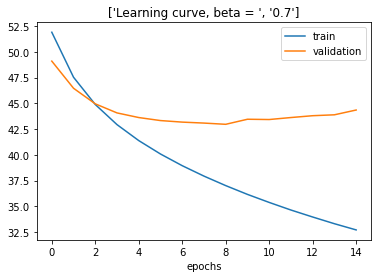

Model evaluation after training with beta = 0.7: cross_entropy: 5.433477401733398, perplexity: 729.5884399414062
Epoch 0: loss=23.463998725578502 val_loss=22.708355233671227 - 26s
Epoch 1: loss=22.546532838423193 val_loss=22.136352335806784 - 26s
Epoch 2: loss=22.01551667529172 val_loss=21.77352722687066 - 26s
Epoch 3: loss=21.63758660193543 val_loss=21.555310225237655 - 26s
Epoch 4: loss=21.343374281021877 val_loss=21.34657021732304 - 26s
Epoch 5: loss=21.094966548172483 val_loss=21.21738068772576 - 28s
Epoch 6: loss=20.881965325388 val_loss=21.09500310758653 - 26s
Epoch 7: loss=20.690603823446533 val_loss=21.013160165198407 - 26s
Epoch 8: loss=20.52114643633054 val_loss=20.920950009018537 - 26s
Epoch 9: loss=20.364046136999058 val_loss=20.8542588658373 - 26s
Epoch 10: loss=20.21762951719221 val_loss=20.812861490935838 - 26s
Epoch 11: loss=20.082249727547556 val_loss=20.754868815357412 - 26s
Epoch 12: loss=19.955916259059375 val_loss=20.70368467213459 - 26s
Epoch 13: loss=19.832551759

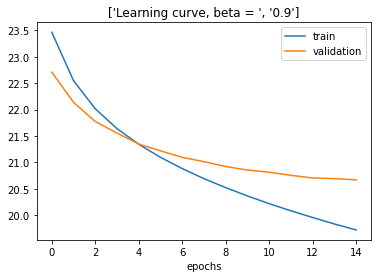

Model evaluation after training with beta = 0.9: cross_entropy: 5.262018203735352, perplexity: 507.6068420410156
Epoch 0: loss=-5.161732163378122 val_loss=-5.271072906899793 - 26s
Epoch 1: loss=-5.3828912416422385 val_loss=-5.4107711336707975 - 26s
Epoch 2: loss=-5.500379391636048 val_loss=-5.503072293407865 - 26s
Epoch 3: loss=-5.589326189328653 val_loss=-5.576161978638173 - 26s
Epoch 4: loss=-5.660481784911123 val_loss=-5.628275557933246 - 26s
Epoch 5: loss=-5.720378399391394 val_loss=-5.667592971111204 - 26s
Epoch 6: loss=-5.771858210576911 val_loss=-5.713151833303994 - 26s
Epoch 7: loss=-5.81774888454676 val_loss=-5.746600284086003 - 26s
Epoch 8: loss=-5.859639694766337 val_loss=-5.76433034960932 - 26s
Epoch 9: loss=-5.896942046279937 val_loss=-5.800646920531687 - 26s
Epoch 10: loss=-5.931383672475309 val_loss=-5.82680431923416 - 26s
Epoch 11: loss=-5.963129038630684 val_loss=-5.842089235465372 - 26s
Epoch 12: loss=-5.992706307706926 val_loss=-5.854037644335451 - 26s
Epoch 13: loss

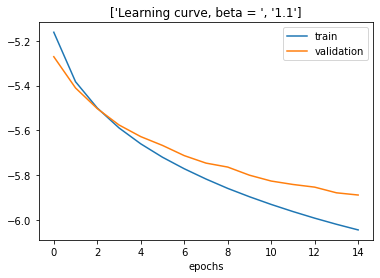

Model evaluation after training with beta = 1.1: cross_entropy: 5.2773823738098145, perplexity: 440.03656005859375
Epoch 0: loss=-0.5353803508855168 val_loss=-0.5851861484727083 - 26s
Epoch 1: loss=-0.607876899712576 val_loss=-0.6277724258424785 - 26s
Epoch 2: loss=-0.6445640421706431 val_loss=-0.6588682235487445 - 26s
Epoch 3: loss=-0.6731588527562717 val_loss=-0.6834648157247752 - 26s
Epoch 4: loss=-0.696939573360472 val_loss=-0.7056218475231789 - 26s
Epoch 5: loss=-0.7172234846459646 val_loss=-0.7211779417673783 - 26s
Epoch 6: loss=-0.734468753655287 val_loss=-0.7320267235156117 - 26s
Epoch 7: loss=-0.7493129783184919 val_loss=-0.7428443833437374 - 26s
Epoch 8: loss=-0.7622900620142011 val_loss=-0.7604189644481877 - 26s
Epoch 9: loss=-0.7740607194621048 val_loss=-0.7687584096193145 - 26s
Epoch 10: loss=-0.7850776406865861 val_loss=-0.7772256514460009 - 26s
Epoch 11: loss=-0.7946793210043223 val_loss=-0.7825572094346178 - 26s
Epoch 12: loss=-0.8038197080437296 val_loss=-0.79330258086

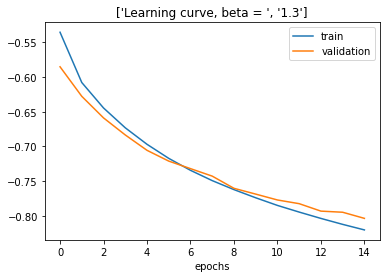

Model evaluation after training with beta = 1.3: cross_entropy: 5.471107482910156, perplexity: 470.2264709472656


In [ ]:
full_softmax = functools.partial(F.softmax, dim=1)
#approx_softmax = ApproximatedSoftmax(q, dist, 1000, bigram=True)
#softmax = functools.partial(F.softmax, dim=1)
cross_entropies_b_full= [] 
perplexities_b_full = []
validation_crossentropies_b_full = []
bin_cross_entropies_b_full= [] 
bin_perplexities_b_full = []

for beta_val in [0.7, 0.9, 1.1, 1.3]:
  
  beta_divergence_loss = functools.partial(beta_divergence, beta=beta_val)

  model = LMModuleBatch(
      n_words=len(word_dict),
      emb_size=60,
      lstm_hidden_size=600,
      n_lstm_layers=1,
  )

  optimizer_pd = torch.optim.Adam(
      model.parameters(), 
      lr=1e-4,
      weight_decay=1e-5, # add L2 regularization
  )

  train_loss, valid_loss, valid_cross_entropy = train_model(
      model=model,
      optimizer=optimizer_pd,
      loss_function=beta_divergence_loss,
      softmax_function=full_softmax,
      train_data=train_tensor,
      dev_data=dev_tensor,
      n_epochs=15,
      batch_size=16,
      bigram_softmax=False,
      verbose=True,
      use_gpu=torch.cuda.is_available(),
  )

  validation_crossentropies_b_full.append(valid_cross_entropy)

  plt.figure()
  plt.plot(train_loss)
  plt.plot(valid_loss)
  plt.legend(["train", "validation"])
  plt.title(['Learning curve, beta = ',str(beta_val)])
  plt.xlabel('epochs')
  plt.show()

  cross_entropy, perplexity = evaluate_model(
      model=model, 
      test_data=dev_tensor,
      batch_size=64,
      use_gpu=torch.cuda.is_available(),
  )
  print(f"Model evaluation after training with beta = {beta_val}: "
        f"cross_entropy: {cross_entropy}, perplexity: {perplexity}")
  cross_entropies_b_full.append(cross_entropy)
  perplexities_b_full.append(perplexity)

  bin_ce, bin_ppl = freq_bins_evaluation(
      model=model,
      test_data=test_tensor,
      word_dict=word_dict,
      word_counter=word_counter,
      n_bins=5,
      batch_size=64,
      use_gpu=torch.cuda.is_available(),
  )
  bin_cross_entropies_b_full.append(bin_ce)
  bin_perplexities_b_full.append(bin_ppl)

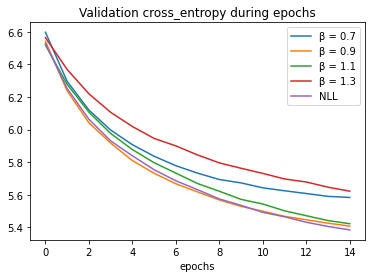

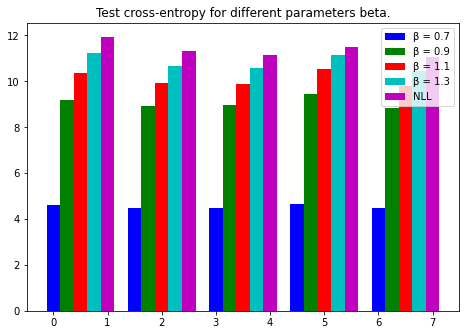

In [ ]:
beta_val = [0.7, 0.9, 1.1, 1.3]
plt.figure()
for valid_cross_entropy in validation_crossentropies_b_full:
  plt.plot(valid_cross_entropy)
for valid_cross_entropy in validation_crossentropies_nll_full:
  plt.plot(valid_cross_entropy)
plt.legend([f"β = {beta}" for beta in beta_val]+['NLL'])
plt.title('Validation cross_entropy during epochs')
plt.xlabel('epochs')
plt.show()

X = np.array([k*1.5 for k in range(5)])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bin_CE = [row[:] for row in bin_cross_entropies_b_full]
bin_CE.append([t for t in bin_cross_entropies_nll_full[0]])

ax.bar(X + 0.00, [bin_CE[k][0] for k in range(len(bin_CE))], color = 'b', width = 0.25, label=f"β = {beta_val[0]}")
ax.bar(X + 0.25, [bin_CE[k][1] for k in range(len(bin_CE))], color = 'g', width = 0.25, label=f"β = {beta_val[1]}")
ax.bar(X + 0.50, [bin_CE[k][2] for k in range(len(bin_CE))], color = 'r', width = 0.25, label=f"β = {beta_val[2]}")
ax.bar(X + 0.75, [bin_CE[k][3] for k in range(len(bin_CE))], color = 'c', width = 0.25, label=f"β = {beta_val[3]}")
ax.bar(X + 1.0, [bin_CE[k][4] for k in range(len(bin_CE))], color = 'm', width = 0.25, label="NLL")

plt.title('Test cross-entropy for different parameters beta.')
ax.legend()

# Experiment - testing different gamma parameter values with gamma divergence as exact objective:



Epoch 0: loss=-15.81225645583113 val_loss=-15.766109465371015 - 27s
Epoch 1: loss=-15.918757588937781 val_loss=-15.787691238963241 - 27s
Epoch 2: loss=-15.934170592056024 val_loss=-15.796590941757145 - 27s
Epoch 3: loss=-15.944484543993545 val_loss=-15.803753289889288 - 27s
Epoch 4: loss=-15.956715406770774 val_loss=-15.814431264052748 - 27s
Epoch 5: loss=-15.97191698977281 val_loss=-15.82482524657935 - 27s
Epoch 6: loss=-15.987401150834302 val_loss=-15.83400617449785 - 27s
Epoch 7: loss=-16.00093558029888 val_loss=-15.841394404617821 - 27s
Epoch 8: loss=-16.013860999376746 val_loss=-15.846605619913811 - 27s
Epoch 9: loss=-16.02472307202477 val_loss=-15.850393695407492 - 27s
Epoch 10: loss=-16.03420696806565 val_loss=-15.854214671684797 - 27s
Epoch 11: loss=-16.04278736358229 val_loss=-15.857527271038597 - 27s
Epoch 12: loss=-16.050400091439553 val_loss=-15.860571764500396 - 27s
Epoch 13: loss=-16.057828898267008 val_loss=-15.863394710520682 - 27s
Epoch 14: loss=-16.06419078732558 val_

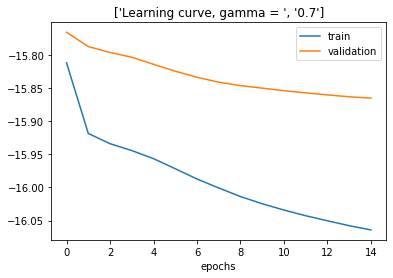

Model evaluation after training with gamma = 0.7: cross_entropy: 19.86467933654785, perplexity: 3189120512.0
Epoch 0: loss=-12.918835895334054 val_loss=-12.860818922162146 - 27s
Epoch 1: loss=-12.998212898445562 val_loss=-12.867526527526609 - 27s
Epoch 2: loss=-13.00345304723129 val_loss=-12.871066858581202 - 27s
Epoch 3: loss=-13.005583828109199 val_loss=-12.872269048247382 - 27s
Epoch 4: loss=-13.006302653863422 val_loss=-12.87250821297478 - 27s
Epoch 5: loss=-13.006800137142532 val_loss=-12.873286685590699 - 27s
Epoch 6: loss=-13.007258617630486 val_loss=-12.87349620055164 - 27s
Epoch 7: loss=-13.007808284927647 val_loss=-12.873791329785286 - 27s
Epoch 8: loss=-13.008287917340379 val_loss=-12.874222104707664 - 27s
Epoch 9: loss=-13.008855956943416 val_loss=-12.874960176489973 - 27s
Epoch 10: loss=-13.009414875616407 val_loss=-12.875069553848254 - 27s
Epoch 11: loss=-13.009903489664667 val_loss=-12.875308425938988 - 27s
Epoch 12: loss=-13.010351026074359 val_loss=-12.875892178289638 

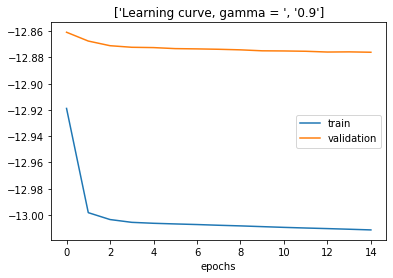

Model evaluation after training with gamma = 0.9: cross_entropy: 21.424760818481445, perplexity: 11208692736.0
Epoch 0: loss=-11.961551554851644 val_loss=-11.986780173232862 - 27s
Epoch 1: loss=-12.08071131759008 val_loss=-11.986826372655552 - 27s
Epoch 2: loss=-12.080721858844818 val_loss=-11.986832760815123 - 27s
Epoch 3: loss=-12.080725126484218 val_loss=-11.986834693033575 - 27s
Epoch 4: loss=-12.080728205241835 val_loss=-11.986836353241735 - 27s
Epoch 5: loss=-12.080730032049818 val_loss=-11.986839994655982 - 27s
Epoch 6: loss=-12.080730483300822 val_loss=-11.98683772618468 - 27s
Epoch 7: loss=-12.080730201241023 val_loss=-11.98683703713491 - 27s
Epoch 8: loss=-12.080729898597182 val_loss=-11.986836155572327 - 27s
Epoch 9: loss=-12.080729701614082 val_loss=-11.986837998624688 - 27s
Epoch 10: loss=-12.080729652714096 val_loss=-11.986836607633666 - 27s
Epoch 11: loss=-12.080729621502982 val_loss=-11.986836376446403 - 27s
Epoch 12: loss=-12.080729512861163 val_loss=-11.98684112201617

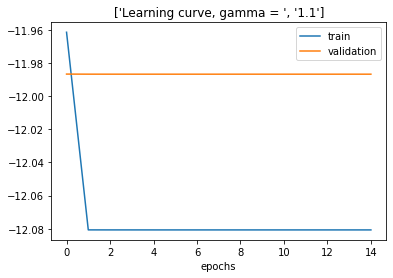

Model evaluation after training with gamma = 1.1: cross_entropy: 27.57779312133789, perplexity: 1891901112320.0
Epoch 0: loss=-11.851156909813607 val_loss=-11.959886104804292 - 27s
Epoch 1: loss=-12.053621225697217 val_loss=-11.959948928438958 - 27s
Epoch 2: loss=-12.053643728204928 val_loss=-11.95995409727909 - 27s
Epoch 3: loss=-12.053649996715913 val_loss=-11.959957884367096 - 27s
Epoch 4: loss=-12.053655145535753 val_loss=-11.959961520839608 - 27s
Epoch 5: loss=-12.053658132335276 val_loss=-11.959964419274716 - 27s
Epoch 6: loss=-12.053659318391919 val_loss=-11.959965164402437 - 27s
Epoch 7: loss=-12.053659300307858 val_loss=-11.959965599919705 - 27s
Epoch 8: loss=-12.05365899041321 val_loss=-11.959965084475241 - 27s
Epoch 9: loss=-12.053658858859187 val_loss=-11.959963158272815 - 27s
Epoch 10: loss=-12.053658719487352 val_loss=-11.959964080873286 - 27s
Epoch 11: loss=-12.053658700166187 val_loss=-11.959961226698937 - 27s
Epoch 12: loss=-12.053658577297666 val_loss=-11.959962427970

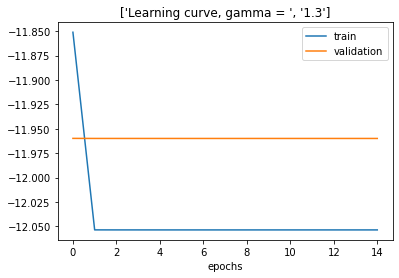

Model evaluation after training with gamma = 1.3: cross_entropy: 29.247112274169922, perplexity: 13754666319872.0


In [ ]:
full_softmax = functools.partial(F.softmax, dim=1)
#approx_softmax = ApproximatedSoftmax(q, dist, 1000, bigram=True)
#softmax = functools.partial(F.softmax, dim=1)
cross_entropies_c_full= [] 
perplexities_c_full = []
validation_crossentropies_c_full = []
bin_cross_entropies_c_full= [] 
bin_perplexities_c_full = []

for gamma_val in [0.7, 0.9, 1.1, 1.3]:
  
  gamma_divergence_loss = functools.partial(gamma_divergence, gamma=gamma_val)

  model = LMModuleBatch(
      n_words=len(word_dict),
      emb_size=60,
      lstm_hidden_size=600,
      n_lstm_layers=1,
  )

  optimizer_pd = torch.optim.Adam(
      model.parameters(), 
      lr=1e-4,
      weight_decay=1e-5, # add L2 regularization
  )

  train_loss, valid_loss, valid_cross_entropy = train_model(
      model=model,
      optimizer=optimizer_pd,
      loss_function=gamma_divergence_loss,
      softmax_function=full_softmax,
      train_data=train_tensor,
      dev_data=dev_tensor,
      n_epochs=15,
      batch_size=16,
      bigram_softmax=False,
      verbose=True,
      use_gpu=torch.cuda.is_available(),
  )

  validation_crossentropies_c_full.append(valid_cross_entropy)

  plt.figure()
  plt.plot(train_loss)
  plt.plot(valid_loss)
  plt.legend(["train", "validation"])
  plt.title(['Learning curve, gamma = ',str(gamma_val)])
  plt.xlabel('epochs')
  plt.show()

  cross_entropy, perplexity = evaluate_model(
      model=model, 
      test_data=dev_tensor,
      batch_size=64,
      use_gpu=torch.cuda.is_available(),
  )
  print(f"Model evaluation after training with gamma = {gamma_val}: cross_entropy: {cross_entropy}, perplexity: {perplexity}")
  cross_entropies_c_full.append(cross_entropy)
  perplexities_c_full.append(perplexity)

  bin_ce, bin_ppl = freq_bins_evaluation(
      model=model,
      test_data=test_tensor,
      word_dict=word_dict,
      word_counter=word_counter,
      n_bins=5,
      batch_size=64,
      use_gpu=torch.cuda.is_available(),
  )
  bin_cross_entropies_c_full.append(bin_ce)
  bin_perplexities_c_full.append(bin_ppl)

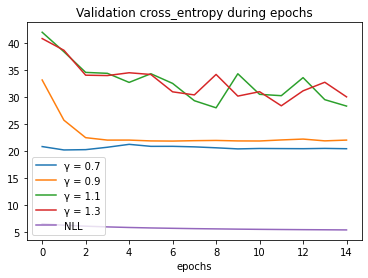

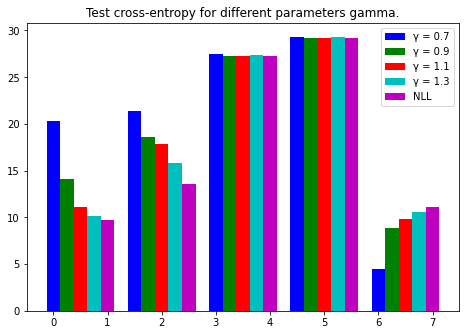

In [ ]:
gamma_val = [0.7, 0.9, 1.1, 1.3]
plt.figure()
for valid_cross_entropy in validation_crossentropies_c_full:
  plt.plot(valid_cross_entropy)
for valid_cross_entropy in validation_crossentropies_nll_full:
  plt.plot(valid_cross_entropy)
plt.legend([f"γ = {gamma}" for gamma in gamma_val]+['NLL'])
plt.title('Validation cross_entropy during epochs')
plt.xlabel('epochs')
plt.show()

X = np.array([k*1.5 for k in range(5)])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bin_CE = [row[:] for row in bin_cross_entropies_c_full]
bin_CE.append([t for t in bin_cross_entropies_nll_full[0]])

ax.bar(X + 0.00, [bin_CE[k][0] for k in range(len(bin_CE))], color = 'b', width = 0.25, label=f"γ = {gamma_val[0]}")
ax.bar(X + 0.25, [bin_CE[k][1] for k in range(len(bin_CE))], color = 'g', width = 0.25, label=f"γ = {gamma_val[1]}")
ax.bar(X + 0.50, [bin_CE[k][2] for k in range(len(bin_CE))], color = 'r', width = 0.25, label=f"γ = {gamma_val[2]}")
ax.bar(X + 0.75, [bin_CE[k][3] for k in range(len(bin_CE))], color = 'c', width = 0.25, label=f"γ = {gamma_val[3]}")
ax.bar(X + 1.0, [bin_CE[k][4] for k in range(len(bin_CE))], color = 'm', width = 0.25, label="NLL")

plt.title('Test cross-entropy for different parameters gamma.')
ax.legend()

#Alpha divergence with alpha = 1.1 using various approximated softmaxes

Epoch 0: loss=18.976427798112955 val_loss=18.238313143529084 - 29s
Epoch 1: loss=18.22406676490223 val_loss=17.886863771019787 - 29s
Epoch 2: loss=17.886505002606953 val_loss=17.622629459521512 - 30s
Epoch 3: loss=17.627821212775633 val_loss=17.418547961755458 - 29s
Epoch 4: loss=17.42320364765564 val_loss=17.28614837595778 - 29s
Epoch 5: loss=17.25066127514301 val_loss=17.16543261025704 - 29s
Epoch 6: loss=17.101739284595602 val_loss=17.049939827198024 - 29s
Epoch 7: loss=16.967976337360472 val_loss=16.97311357020486 - 29s
Epoch 8: loss=16.84792227971794 val_loss=16.88565465647862 - 29s
Epoch 9: loss=16.736993439941724 val_loss=16.83507274232454 - 29s
Epoch 10: loss=16.635758573712113 val_loss=16.76152893537375 - 29s
Epoch 11: loss=16.54497339769985 val_loss=16.70905879710197 - 29s
Epoch 12: loss=16.458215316218652 val_loss=16.665997545554443 - 29s
Epoch 13: loss=16.37800630976766 val_loss=16.629683091628454 - 29s
Epoch 14: loss=16.302667060997788 val_loss=16.58651927157428 - 29s
Trai

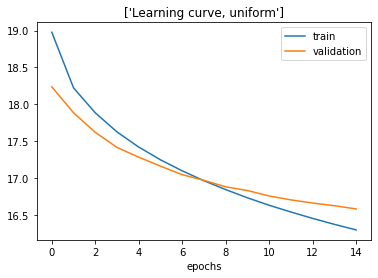

Model evaluation after training with alpha = 1.1 using uniform: cross_entropy: 5.296755790710449, perplexity: 457.7894287109375
Epoch 0: loss=18.273753831593364 val_loss=17.72834825917263 - 29s
Epoch 1: loss=17.61686925903912 val_loss=17.385908778978955 - 29s
Epoch 2: loss=17.281520752621642 val_loss=17.20265537616371 - 29s
Epoch 3: loss=17.03939672690959 val_loss=17.06051785842022 - 29s
Epoch 4: loss=16.84628635081531 val_loss=16.963425116200735 - 29s
Epoch 5: loss=16.68289599413507 val_loss=16.880156227104727 - 29s
Epoch 6: loss=16.538868841472475 val_loss=16.830297227786605 - 29s
Epoch 7: loss=16.40916389406707 val_loss=16.775086456473293 - 29s
Epoch 8: loss=16.292205740633296 val_loss=16.72223669969192 - 29s
Epoch 9: loss=16.182356803986586 val_loss=16.68457872677099 - 29s
Epoch 10: loss=16.08039263596231 val_loss=16.665125443171373 - 29s
Epoch 11: loss=15.986395464835356 val_loss=16.656836744678724 - 29s
Epoch 12: loss=15.896631414683664 val_loss=16.62249428974336 - 29s
Epoch 13: 

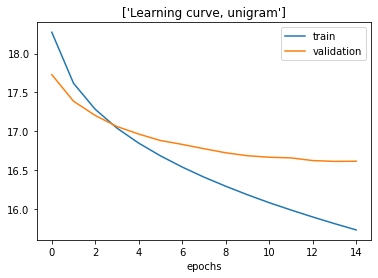

Model evaluation after training with alpha = 1.1 using unigram: cross_entropy: 7.587018013000488, perplexity: 3768.02685546875
Epoch 0: loss=24.330049265158927 val_loss=21.765324352137316 - 31s
Epoch 1: loss=22.883060968995494 val_loss=21.03908261715931 - 31s
Epoch 2: loss=22.240466411623927 val_loss=20.569805753419384 - 31s
Epoch 3: loss=21.773305727816673 val_loss=20.22154378462618 - 31s
Epoch 4: loss=21.407559489960303 val_loss=19.935392489177204 - 31s
Epoch 5: loss=21.089283690768315 val_loss=19.70709902052643 - 31s
Epoch 6: loss=20.742513511608678 val_loss=19.398206120224362 - 31s
Epoch 7: loss=20.457426505098535 val_loss=19.188571186415356 - 31s
Epoch 8: loss=20.239483491309468 val_loss=19.0395998324836 - 31s
Epoch 9: loss=20.024213454719032 val_loss=18.871120188712887 - 31s
Epoch 10: loss=19.82873713310449 val_loss=18.729072701219618 - 31s
Epoch 11: loss=19.660486861514993 val_loss=18.607767202164663 - 31s
Epoch 12: loss=19.509202818374263 val_loss=18.520617414599805 - 31s
Epoch

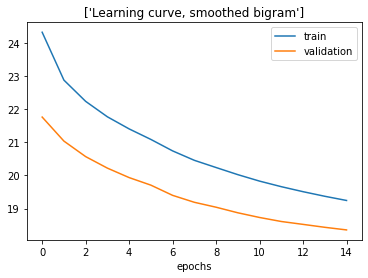

Model evaluation after training with alpha = 1.1 using smoothed bigram: cross_entropy: 6.135373115539551, perplexity: 1087.2828369140625


In [ ]:
cross_entropies_a_sample= [] 
perplexities_a_sample = []
validation_crossentropies_a_sample = []
bin_cross_entropies_a_sample= [] 
bin_perplexities_a_sample = []
approx_type = ["uniform", "unigram", "smoothed bigram"]

alpha_divergence_loss = functools.partial(alpha_divergence, alpha=1.1)

dist_unigram = get_unigram_dist(train_data, word_dict).to(
    torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

dist_uniform = get_uniform_dist(word_dict).to(
    torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

dist_bigram_kn_smooth = get_bigram_kn_smooth(train_data, word_dict, alpha=0.75).to(
    torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

dist = dist_unigram
dist_q = [dist_unigram, dist_uniform, dist_bigram_kn_smooth]
bsfs = [False, False, True]
for i in range(3):
  q = dist_q[i]
  bsf = bsfs[i]
  approx_softmax = ApproximatedSoftmax(q, dist, 1000, bigram=bsf)
  model = LMModuleBatch(
      n_words=len(word_dict),
      emb_size=60,
      lstm_hidden_size=600,
      n_lstm_layers=1,
  )

  optimizer_pd = torch.optim.Adam(
      model.parameters(), 
      lr=1e-4,
      weight_decay=1e-5, # add L2 regularization
  )

  train_loss, valid_loss, valid_cross_entropy = train_model(
      model=model,
      optimizer=optimizer_pd,
      loss_function=alpha_divergence_loss,
      softmax_function=approx_softmax,
      train_data=train_tensor,
      dev_data=dev_tensor,
      n_epochs=15,
      batch_size=16,
      bigram_softmax=bsf,
      verbose=True,
      use_gpu=torch.cuda.is_available(),
  )

  validation_crossentropies_a_sample.append(valid_cross_entropy)

  plt.figure()
  plt.plot(train_loss)
  plt.plot(valid_loss)
  plt.legend(["train", "validation"])
  plt.title([f'Learning curve, {approx_type[i]}'])
  plt.xlabel('epochs')
  plt.show()

  cross_entropy, perplexity = evaluate_model(
      model=model, 
      test_data=dev_tensor,
      batch_size=64,
      use_gpu=torch.cuda.is_available(),
  )
  print(f"Model evaluation after training with alpha = 1.1 using {approx_type[i]}: cross_entropy: {cross_entropy}, perplexity: {perplexity}")
  cross_entropies_a_sample.append(cross_entropy)
  perplexities_a_sample.append(perplexity)

  bin_ce, bin_ppl = freq_bins_evaluation(
      model=model,
      test_data=test_tensor,
      word_dict=word_dict,
      word_counter=word_counter,
      n_bins=5,
      batch_size=64,
      use_gpu=torch.cuda.is_available(),
  )
  bin_cross_entropies_a_sample.append(bin_ce)
  bin_perplexities_a_sample.append(bin_ppl)

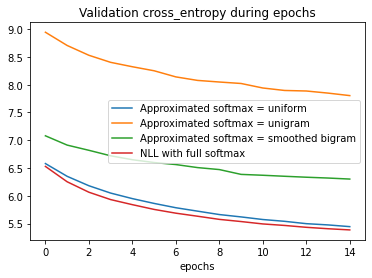

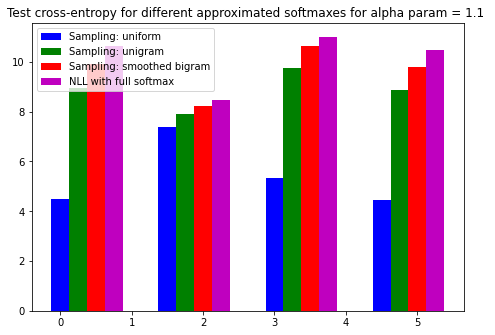

In [ ]:
approx_type = ["uniform", "unigram", "smoothed bigram"]
plt.figure()
for valid_cross_entropy in validation_crossentropies_a_sample:
  plt.plot(valid_cross_entropy)
for valid_cross_entropy in validation_crossentropies_nll_full:
  plt.plot(valid_cross_entropy)
plt.legend([f"Approximated softmax = {as_t}" for as_t in approx_type]+['NLL with full softmax'])
plt.title('Validation cross_entropy during epochs')
plt.xlabel('epochs')
plt.show()

X = np.array([k*1.5 for k in range(4)])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

bin_CE = [row[:] for row in bin_cross_entropies_a_sample]
bin_CE.append([t for t in bin_cross_entropies_nll_full[0]])

ax.bar(X + 0.00, [bin_CE[k][0] for k in range(len(bin_CE))], color = 'b', width = 0.25, label=f"Sampling: {approx_type[0]}")
ax.bar(X + 0.25, [bin_CE[k][1] for k in range(len(bin_CE))], color = 'g', width = 0.25, label=f"Sampling: {approx_type[1]}")
ax.bar(X + 0.50, [bin_CE[k][2] for k in range(len(bin_CE))], color = 'r', width = 0.25, label=f"Sampling: {approx_type[2]}")
ax.bar(X + 0.75, [bin_CE[k][3] for k in range(len(bin_CE))], color = 'm', width = 0.25, label="NLL with full softmax")

plt.title('Test cross-entropy for different approximated softmaxes for alpha param = 1.1 ')
ax.legend()

# Noise contrastive estimation - unfinished

In [ ]:
import torch.nn.functional as F


def logsumexp(x, dim=None, keepdim=False):
    if dim is None:
        x, dim = x.view(-1), 0
    xm, _ = torch.max(x, dim, keepdim=True)
    x = torch.where(
        (xm == float('inf')) | (xm == float('-inf')),
        xm,
        xm + torch.log(torch.sum(torch.exp(x - xm), dim, keepdim=True)))
    return x if keepdim else x.squeeze(dim)

def train_model_nce(
    model: nn.Module,
    noise_dist: torch.Tensor,
    optimizer: torch.optim.Optimizer,
    train_data: List[torch.Tensor],
    dev_data: List[torch.Tensor],
    n_epochs: int = 10,
    batch_size: int = 16,
    bigram_softmax: bool = False,
    verbose: bool = True,
    use_gpu: bool = False,
    num_noise_samples = 5,
    divergence='alpha',
    param=1.0,
    
) -> Tuple[List[float]]:
    """Perform training on given model. Composes given training 
    and validation data into batches of size `batch_size`.
    
    Parameters:
        model: model to train. 
        optimizer: optimizer to use during the training.
        loss_function: loss function that takes logits and target tensors.
        train_data: list of training data tensors.
        dev_data: list of validation data tensors.
        n_epochs: number of epochs.
        batch_size: size of batches to use.
        verbose: print information during training.
        use_gpu: whether to use gpu device during training.
    """
    time_start = time.time()

    device = torch.device('cuda' if use_gpu else 'cpu')
        
    model.to(device)
    
    # Pack training data into batched, data is sorted before 
    # so sentences within a batch have similar lenght hence
    # amount of padding is minimized.
    train_inputs, train_labels, train_masks = create_batches(
        train_data, 
        padding_idx=model.embeddings.padding_idx,
        batch_size=batch_size,
    )
    dev_inputs, dev_labels, dev_masks = create_batches(
        dev_data,
        padding_idx=model.embeddings.padding_idx,
        batch_size=batch_size,
    )

    # This index will be used to access batches in random order
    # after shuffling.
    data_index = list(range(len(train_inputs)))
    train_loss = []
    validation_loss = []
    _dist = torch.distributions.Categorical(probs=noise_dist).probs
    noise_logits = torch.distributions.Categorical(probs=noise_dist).logits
    for epoch in range(n_epochs):
        # Shuffle indices to access batches in random order.
        random.shuffle(data_index)

        # ~~~~~~~~~ Training Loop ~~~~~~~~~
        epoch_start_time = time.time()
        epoch_loss = 0
        epoch_norm = 0

        model.train()
        for batch_idx in data_index:
            optimizer.zero_grad()

            # Get batch data for current iteration.
            batch_input = train_inputs[batch_idx].to(device)
            batch_labels = train_labels[batch_idx].to(device)
            batch_mask = train_masks[batch_idx].to(device)

            # Sample from noise distribution         
            noise_samples_idx = _dist.multinomial(
            num_samples=num_noise_samples,
            replacement=True,
            )
            

            # Pass the data through LSTM model.
            batch_model_logits = model(batch_input)[batch_mask]
            
            true_word_model_dist_logits = batch_model_logits[batch_labels[batch_mask]]
            noise_word_model_dist_logits = batch_model_logits[noise_samples_idx]

            true_word_noise_dist_logits = noise_logits[batch_labels[batch_mask]]
            noise_word_noise_dist_logits = noise_logits[noise_samples_idx]

            model_dist_logits = torch.cat([true_word_model_dist_logits, noise_word_model_dist_logits], dim=1)
            noise_dist_logits = torch.cat([true_word_noise_dist_logits, noise_word_noise_dist_logits], dim=1)
            #noise_dist_logits = torch.cat([true_word_noise_dist_logits, noise_word_noise_dist_logits.repeat(batch_labels[batch_mask].size(0), 1)], dim=1)

            output = model_dist_logits - noise_dist_logits

            # Set partition function to 1
            #output -= torch.logsumexp(output[:,1:], dim=1).unsqueeze(1)

            out_sig = torch.sigmoid(output)
            new_targets = torch.zeros_like(batch_labels[batch_mask])
            labels = torch.zeros_like(output).scatter_(1, new_targets.unsqueeze(1), 1.0)

            if divergence == 'alpha':
              pass
            elif divergence == 'beta':
              pass
            elif divergence == 'gamma':
              pass
            else:
              batch_loss = F.binary_cross_entropy_with_logits(output,labels,reduction='sum')   

            # # Transform logits into probabilities.
            # if not bigram_softmax:
            #     batch_probas = softmax_function(batch_logits[batch_mask])
            # else:
            #     batch_probas = softmax_function(
            #         batch_logits[batch_mask], 
            #         batch_input[batch_mask],
            #     )
            # # Compute loss.
            # batch_loss = loss_function(
            #     batch_probas,
            #     batch_labels[batch_mask],
            # )


            # Normalize by number of letters predicted.
            batch_norm = sum(len(s)-1 for s in batch_input)
            loss = batch_loss / batch_norm
            
            epoch_loss += batch_loss.item()
            epoch_norm += batch_norm

            loss.backward()
            optimizer.step()
        # endfor
        train_loss.append(epoch_loss/epoch_norm)

        # ~~~~~~~~~ Validation Loop ~~~~~~~~~
        val_loss = 0
        val_norm = 0

        model.eval()
        with torch.no_grad():
            for dev_input, dev_label, dev_mask in zip(dev_inputs, dev_labels, dev_masks):
                dev_input = dev_input.to(device)
                dev_label = dev_label.to(device)
                dev_mask = dev_mask.to(device)
                
                dev_logits = model(dev_input)
                # Sample from noise distribution         
                noise_samples_idx = _dist.multinomial(
                num_samples=num_noise_samples,
                replacement=True,
                )
                

                # Pass the data through LSTM model.
                dev_model_logits = model(dev_input)[dev_mask]
                
                true_word_model_dist_logits = dev_model_logits[dev_labels[dev_mask]]
                noise_word_model_dist_logits = dev_model_logits[noise_samples_idx]

                true_word_noise_dist_logits = noise_logits[dev_labels[dev_mask]]
                noise_word_noise_dist_logits = noise_logits[noise_samples_idx]

                model_dist_logits = torch.cat([true_word_model_dist_logits, noise_word_model_dist_logits], dim=1)
                noise_dist_logits = torch.cat([true_word_noise_dist_logits, noise_word_noise_dist_logits], dim=1)

                output = model_dist_logits - noise_dist_logits

                # Set partition function to 1
                #output -= torch.logsumexp(output[:,1:], dim=1).unsqueeze(1)

                out_sig = torch.sigmoid(output)
                new_targets = torch.zeros_like(dev_labels[dev_mask])
                labels = torch.zeros_like(output).scatter_(1, new_targets.unsqueeze(1), 1.0)

                if divergence == 'alpha':
                  #
                  pass
                elif divergence == 'beta':
                  #
                  pass
                elif divergence == 'gamma':
                  #
                  pass
                else:
                  dev_loss = F.binary_cross_entropy_with_logits(output,labels,reduction='sum')  
                val_loss += dev_loss.item()
                dev_norm = sum(len(s)-1 for s in dev_input)               
                val_norm += dev_norm

        validation_loss.append(val_loss/val_norm)

        # ~~~~~~~~~ End of Epoch ~~~~~~~~~
        if verbose:
            epoch_total_time = int(time.time() - epoch_start_time)
            print(f"Epoch {epoch}: loss={epoch_loss/epoch_norm} "
                  f"val_loss={val_loss/val_norm} - {epoch_total_time}s")
    if verbose:
        total_time = int(time.time() - time_start)
        print(f"Training finished in {total_time}s")
    return train_loss, validation_loss